Input dropout + Sparse

In [44]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from codes.utils import *
from codes.process import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_X_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch
        
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [469]:
# For fold
fold_num = 1
in_fold_num = 1
y_value = 'y'
ex_num = 100

# For model
learning_rate = 0.01
sparsity_target = 0.2
sparsity_weight = 0.3
dropout_rate = 0.3

# For training
n_epochs = 1000
batch_size = 256
loss_test_min = 1000

In [463]:
# Train data
bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

# Test data
bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

# Data set
X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_test = bed_data_test[y_value].to_numpy().astype(np.int32)

In [472]:
##### Init #####
reset_graph(random_seed)
training = tf.placeholder_with_default(False, shape=(), name='training')
n_inputs = X_train.shape[1]
n_hidden = n_inputs
n_outputs = n_inputs

##### Build Model #####
# input
X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])

# layers
X_drop = tf.layers.dropout(X_input, dropout_rate, training=training)  # Input dropout
hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2r, n_outputs)

# output
logits = tf.layers.dense(hidden2r, n_outputs)

##### Construct Loss #####
# sparsity loss
hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)

sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden_mean))

# mean info
r_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 
mse = tf.reduce_mean(tf.square(logits-X_input))
mae = tf.reduce_mean(tf.abs(logits-X_input))
#reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

# Loss
loss = mae + sparsity_weight * sparsity_loss

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [473]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print(f'\r{100 * iteration // n_batches}%', end='')
            sys.stdout.flush()
            X_batch = next(shuffle_X_batch(X_train, batch_size))
            sess.run(training_op, feed_dict={X_input: X_batch})
        if epoch % 100 == 0 or epoch == n_epochs - 1:
            mae_train, r_loss_train, s_loss_train, loss_train = sess.run([mae, r_loss, sparsity_loss, loss], feed_dict={X_input: X_batch})
            mae_test, r_loss_test, s_loss_test, loss_test = sess.run([mae, r_loss, sparsity_loss, loss], feed_dict={X_input: X_test})
            print(f'\r{epoch} Train - MAE: {mae_train: 4f}, Cross entropy: {r_loss_train:.4f}, \tSparsity loss: {s_loss_train:.4f} \tLoss:, {loss_train:.4f}')
            print(f'\r{epoch} Test  - MAE: {mae_test: 4f}, Cross entropy: {r_loss_test:.4f}, \tSparsity loss: {s_loss_test:.4f} \tLoss:, {loss_test:.4f}')
            if loss_test_min > loss_test:
                loss_test_min = loss_test
                print('Save model')
                saver.save(sess, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num))

0 Train - MAE:  0.273204, Cross entropy: 0.6601, 	Sparsity loss: 48.2402 	Loss:, 14.7452
0 Test  - MAE:  0.264066, Cross entropy: 0.6650, 	Sparsity loss: 161.6570 	Loss:, 48.7612
Save model
100 Train - MAE:  0.163481, Cross entropy: 0.5962, 	Sparsity loss: 0.1045 	Loss:, 0.1948
100 Test  - MAE:  0.170169, Cross entropy: 0.6105, 	Sparsity loss: 0.3327 	Loss:, 0.2700
Save model
200 Train - MAE:  0.112104, Cross entropy: 0.5458, 	Sparsity loss: 0.0150 	Loss:, 0.1166
200 Test  - MAE:  0.101509, Cross entropy: 0.5634, 	Sparsity loss: 0.0849 	Loss:, 0.1270
Save model
83%

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from /home2/jpark/Projects/prs/model/cv_1_1_test_y_100
INFO:tensorflow:Restoring parameters from /home2/jpark/Projects/prs/model/cv_1_1_test_y_100


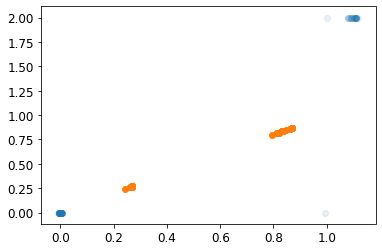

In [482]:
target = X_test[2:3]

def get_reconstructed(X_feed, logits, model_path):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        logits_val = logits.eval(feed_dict={X_input: X_feed})
        return logits_val
    
def get_code_0(X_feed, logits, model_path):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        hidden0_val = hidden0.eval(feed_dict={X_input: X_feed})
        return hidden0_val

return_val = get_reconstructed(target, logits, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num))
plt.scatter(return_val[0], target[0], alpha=0.1)
code_0 = get_code_0(X_test, logits, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num))
plt.scatter(code_0, code_0, alpha=1)

In [519]:
pd.DataFrame(y_test, columns=['y'])

,y
0,0
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [520]:
pd.DataFrame(code_0, columns=['X'])

,X
0,0.833514
1,0.833822
2,0.869191
3,0.869579
4,0.832944
...,...
780,0.869581
781,0.834013
782,0.869143
783,0.833779


In [522]:
pd.DataFrame(y_test, columns=['y'])

,y
0,0
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [543]:
temp_df = pd.concat([pd.DataFrame(code_0, columns=['X']), pd.DataFrame(y_test, columns=['y'])], axis=1)

In [544]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

model = LogisticRegressionCV(penalty='l2', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga',  random_state=2)

In [545]:
temp_df

,X,y
0,0.833514,0
1,0.833822,0
2,0.869191,0
3,0.869579,0
4,0.832944,0
...,...,...
780,0.869581,0
781,0.834013,0
782,0.869143,0
783,0.833779,0


In [547]:
temp_df

,X,y
0,0.591669,0
1,0.592849,0
2,0.728547,0
3,0.730036,0
4,0.589479,0
...,...,...
780,0.730045,0
781,0.593583,0
782,0.728364,0
783,0.592683,0


In [546]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

for col in ['X']:
    scaler = normalize(temp_df, col)

fitted_model = model.fit(temp_df[['X']], temp_df[['y']])

/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python

In [548]:

    
roc_auc_score(temp_df[['y']], fitted_model.decision_function(temp_df[['X']]))

0.5808126868318386

In [542]:

    
roc_auc_score(temp_df[['y']], fitted_model.decision_function(temp_df[['X']]))

0.5808126868318386

In [ ]:
# Train
model = LogisticRegressionCV(penalty='l2', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga',  random_state=2)
fitted_model = model.fit(X_train, y_train)

# For test data
print('@ Test scores')
test_pred = fitted_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_score = precision_recall_fscore_support(y_test, test_pred)
test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
test_result_list.append([model_name, test_acc, test_score, test_auc])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f41d6e16b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f41d6e25208>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f41d6e16828>],
 'medians': [<matplotlib.lines.Line2D at 0x7f41d6e25898>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f41d6e25be0>],
 'means': []}

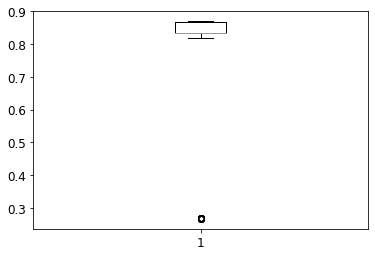

In [508]:
plt.boxplot(code_0[y_test==1])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f41d6dff240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f41d6dff8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f41d6df2ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f41d6dfff60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f41d6d892e8>],
 'means': []}

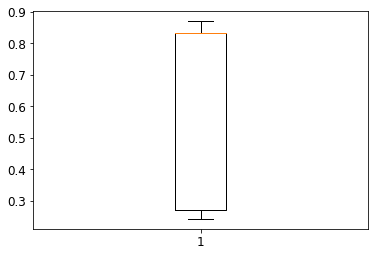

In [509]:
plt.boxplot(code_0[y_test==0])

['r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'b',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r'